# <center>Movie Recommendation</center>  

**Team:** Martin Alonso, LaRue Brown, Rashad Davis  
**Class:** IST 718 - Big Data Analytics  
**Assignment:** Final Project  

## Introduction  
For this assignement, we want to build a movie recommendation system capable of showing tag trends over time as well as understand how a user's movie genre preference changes over time. For this project, we'll be using the [Movie Lens](https://grouplens.org/datasets/movielens/20m/) database, working through 20 million ratings for 27,000 movies provided by users over the past 20 years. 
    
## Setup  
Prior to loading any data or building any algorithms, we must set up our working environment.  This includes installing necessary packages, adjusting settings, and creating connections to necessary resources.  Let's first import all the packages we will need for our analysis.  

In [1]:
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
from lightfm.evaluation import precision_at_k
from pyspark.sql.functions import substring
from IPython.display import Image, display
from nltk.tokenize import word_tokenize
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import matplotlib.pyplot as plt
from nltk import PorterStemmer
from datetime import timedelta 
from datetime import datetime
from tempfile import mkdtemp
from lightfm import LightFM
import tmdbsimple as tmdb
from scipy import spatial
from io import StringIO
import os.path as path
import seaborn as sns
import pandas as pd
import numpy as np
import ibmos2spark
import scipy as sp
import requests
import warnings
import json
import nltk
import re

/usr/local/src/conda3_runtime/home/envs/DSX-Python35-Spark/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/local/src/conda3_runtime/home/envs/DSX-Python35-Spark/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/local/src/conda3_runtime/home/envs/DSX-Python35-Spark/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/local/src/conda3_runtime/home/envs/DSX-Python35-Spark/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/local/src/conda3_runtime/home/envs/DSX-Python35-Spark/lib/python3.5/importlib/_bootstra

Next, we'll adjust the settings, adjusting the size of all plots and the edge color for our graphs. We will also suppress any warning messages.  

In [2]:
plt.rcParams['figure.figsize'] = [20, 10]
plt.rcParams['patch.force_edgecolor'] = True
warnings.filterwarnings('ignore')

Since we will leverage the TMDB database, we will also store the api key.  

In [3]:
tmdb.API_KEY = '5b7d7ad39e8fb387ca8678b403a79918'

Lastly, we will set up connections for data stored in various locations.  Some of the data are already stored in Watson Studio's object storage and will be loaded as a Pandas dataframe.  The connection to the object follows. 

In [4]:
# @hidden_cell
# This function accesses a file in your Object Storage. The definition contains your credentials.
# You might want to remove those credentials before you share your notebook.
def get_object_storage_file_with_credentials_c12ec18578414b24a0c0d4f9e45ee656(container, filename):
    """This functions returns a StringIO object containing
    the file content from Bluemix Object Storage."""

    url1 = ''.join(['https://identity.open.softlayer.com', '/v3/auth/tokens'])
    data = {'auth': {'identity': {'methods': ['password'],
            'password': {'user': {'name': 'member_cea37bfd20b64af3c43c7f00792f5cc8c8e376fd','domain': {'id': '39ab97bf8c6646b0a0c01b8c23c5cb7e'},
            'password': 'uy8oI35ci-Oh.TF]'}}}}}
    headers1 = {'Content-Type': 'application/json'}
    resp1 = requests.post(url=url1, data=json.dumps(data), headers=headers1)
    resp1_body = resp1.json()
    for e1 in resp1_body['token']['catalog']:
        if(e1['type']=='object-store'):
            for e2 in e1['endpoints']:
                        if(e2['interface']=='public'and e2['region']=='dallas'):
                            url2 = ''.join([e2['url'],'/', container, '/', filename])
    s_subject_token = resp1.headers['x-subject-token']
    headers2 = {'X-Auth-Token': s_subject_token, 'accept': 'application/json'}
    resp2 = requests.get(url=url2, headers=headers2)
    return StringIO(resp2.text)



We will also use Apache Spark throughout this process.  The connection to Spark is below.  

In [5]:
# @hidden_cell
credentials = {
    'auth_url': 'https://identity.open.softlayer.com',
    'project_id': '811d1c744e5b493795422d56bf848985',
    'region': 'dallas',
    'user_id': '97fc8a750fbd4fa99d69eeab643ac77a',
    'username': 'member_cea37bfd20b64af3c43c7f00792f5cc8c8e376fd',
    'password': 'uy8oI35ci-Oh.TF]'
}

configuration_name = 'os_c12ec18578414b24a0c0d4f9e45ee656_configs'
bmos = ibmos2spark.bluemix(sc, credentials, configuration_name)
spark = SparkSession.builder.getOrCreate()

## Data Acquisition  

Having completed the setup, we'll proceed to load our data, which is spread across six comma-separated value (csv) files.

In [6]:
ratings = pd.read_csv(get_object_storage_file_with_credentials_c12ec18578414b24a0c0d4f9e45ee656('iSchool2UAASpark', 'ml_20m_ratings.csv'))
tags = pd.read_csv(get_object_storage_file_with_credentials_c12ec18578414b24a0c0d4f9e45ee656('iSchool2UAASpark', 'ml_20m_tags.csv'))
links = pd.read_csv(get_object_storage_file_with_credentials_c12ec18578414b24a0c0d4f9e45ee656('iSchool2UAASpark', 'ml_20m_links.csv'))
movies = pd.read_csv(get_object_storage_file_with_credentials_c12ec18578414b24a0c0d4f9e45ee656('iSchool2UAASpark', 'ml_20m_movies.csv'))

#Load an additional tag and movie csv for use with the second model. We will definitely need a clean file.
tags2 = pd.read_csv(get_object_storage_file_with_credentials_c12ec18578414b24a0c0d4f9e45ee656('iSchool2UAASpark', 'ml_20m_tags.csv'))
movies2 = pd.read_csv(get_object_storage_file_with_credentials_c12ec18578414b24a0c0d4f9e45ee656('iSchool2UAASpark', 'ml_20m_movies.csv'))

### Ratings  

Let's first look at the `ratings` table. The `ratings` dataframe has four columns: `userId`, `movieId`, `rating` and `timestamp`. The first two columns are unique identifiers, allowing us to identify both users and movies. The third column lists the user's `rating` for the movie, with values ranging from 0.5 to 5 (in half-value increments.) The last column, `timestamp`, represents the time the `rating` was submitted, not the date the movie was released. This value measures the number of seconds since January 1, 1970 12:00:00 (UTC timezone.)  
For the benefit of our readers, we will display the first five observations of the table.  

In [7]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


We'll also print the table information, which show that all the columns in the `ratings` dataframe are numeric: `userId`, `movieId`, and `timestamp` are stored as integers; `rating` is stored as a floating point number. The information also shows that there are 20,000,263 records in the data frame, one for each rating score.   

In [8]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000263 entries, 0 to 20000262
Data columns (total 4 columns):
userId       int64
movieId      int64
rating       float64
timestamp    int64
dtypes: float64(1), int64(3)
memory usage: 610.4 MB


Because `userId` and `movieId` are not numbers but identifiers, they will be converted to objects. However, though `rating` is also a categorical variable, we will not convert it as ratings can be averaged to show how people feel towards any specific movie.

In [9]:
# Columns to be converted to objects
to_object = ['userId', 'movieId']
ratings[to_object] = ratings[to_object].astype(object)
to_object = None

# Make sure that rating column remains as float.
ratings.rating = ratings.rating.astype(float)

Next, we'll check the `ratings` dataframe for null values.  

In [10]:
ratings.isnull().values.any()

False

Next, we want to convert the timestamp variable to more understandable format.

In [11]:
ratings['ratingDateTime'] = datetime.strptime('Jan 1 1970 12:00AM', '%b %d %Y %I:%M%p') + pd.to_timedelta(ratings.timestamp, 's')

We'll also add four columns to the dataframe: `ratingDate`, `ratingYear`, `ratingMonth`, and `ratingDay`. With these newly created columns, the timestamp variable will be dropped.

In [12]:
# Create columns for rating Date, Year, Month, and Day for easier understanding of date. 
ratings['ratingDate'] = pd.DatetimeIndex(ratings['ratingDateTime']).date
ratings['ratingYear'] = pd.DatetimeIndex(ratings['ratingDateTime']).year
ratings['ratingMonth'] = pd.DatetimeIndex(ratings['ratingDateTime']).month
ratings['ratingDay'] = pd.DatetimeIndex(ratings['ratingDateTime']).day

# Drop timestamp variable, as it has become obsolete
ratings = ratings.drop('timestamp', axis = 1)
ratings.head()

,userId,movieId,rating,ratingDateTime,ratingDate,ratingYear,ratingMonth,ratingDay
0,1,2,3.5,2005-04-02 23:53:47,2005-04-02,2005,4,2
1,1,29,3.5,2005-04-02 23:31:16,2005-04-02,2005,4,2
2,1,32,3.5,2005-04-02 23:33:39,2005-04-02,2005,4,2
3,1,47,3.5,2005-04-02 23:32:07,2005-04-02,2005,4,2
4,1,50,3.5,2005-04-02 23:29:40,2005-04-02,2005,4,2


We want to understand how movies are distributed by ratings. For this, we'll build a bar plot showing the number of movies per rating. 

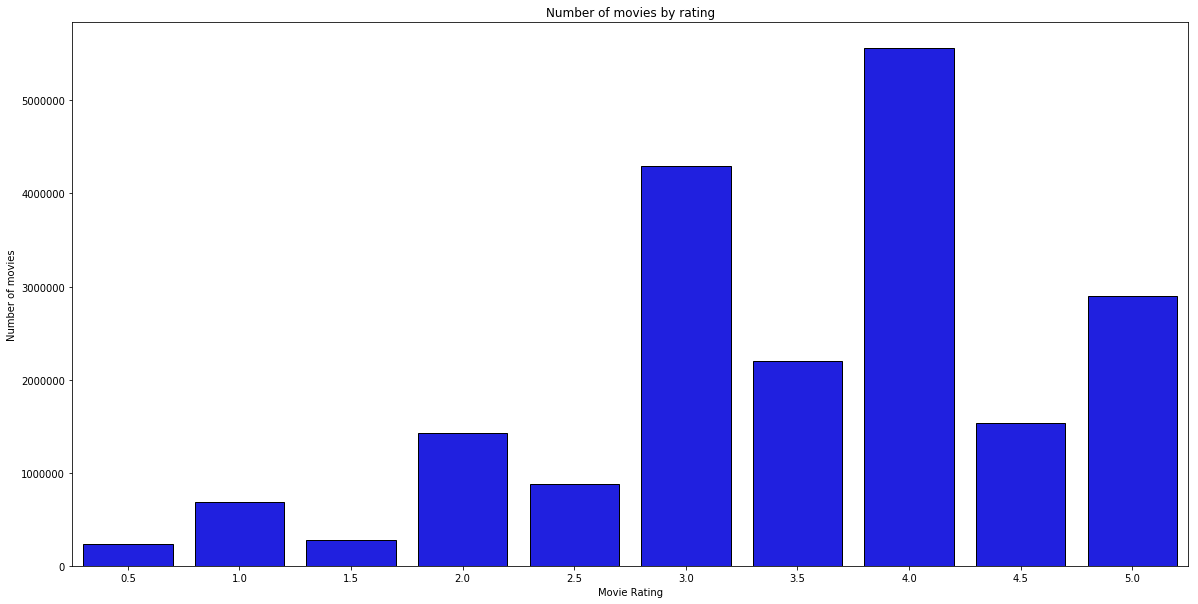

In [13]:
sns.countplot(x='rating', data=ratings, color='blue')
_ = plt.xlabel('Movie Rating')
_ = plt.ylabel('Number of movies')
_ = plt.title('Number of movies by rating')
plt.show()

From this graph, it appears that the higher a movie is rated, the more times it will be tagged by a user. This makes sense as higher-rated movies tend to have larger audiences than lower rated movies. When we think of really popular movies, like summer blockbusters, those are seen by larger audiences than less popular movies. There are of course exceptions, but in general, this makes sense.  
  
Let's now take a look at the how ratings evolve per year.

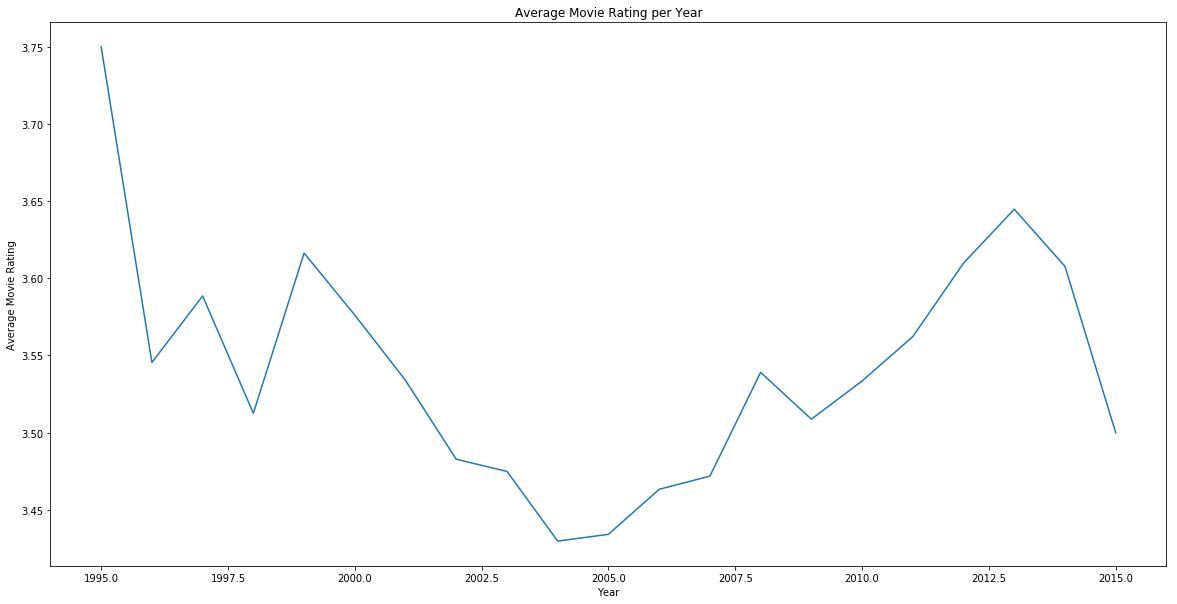

In [14]:
# Convert ratingYear to object
ratings.ratingYear = ratings.ratingYear.astype(object)
ratings_per_year = ratings.groupby('ratingYear')['rating'].mean().reset_index()

# Lineplot to gauge average rating per year
sns.lineplot(x='ratingYear', y='rating', data=ratings_per_year)
_ = plt.xlabel('Year')
_ = plt.ylabel('Average Movie Rating')
_ = plt.title("Average Movie Rating per Year")
plt.show()
ratings_per_year = None

When the data set was started, the average movie rating was 3.75. But as the years go by, the average rating has gone down. This is not to say that movies released in these years have gotten worse, it's that the reviewers have been more scrutinous.
However, the trend started to recover, reaching a peak of 3.65 before falling again by 2015. We'll have to check the movies being reviewed in these years to get an idea of what movies are driving this trend. 

### Movies  

We will use some of the same techniques to analyze the `movies` dataframe.  Let's first look at the data set and it's data types.  
Notice two key things here: 
1. Most of the movies have the year at the end of the `title`; 
2. Some movies have more than one genre in the `genres` column.  These `genres` are separated by a vertical pipe if there are more than one. 

In [15]:
# Print first 5 rows of movies
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [16]:
# movies info
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 3 columns):
movieId    27278 non-null int64
title      27278 non-null object
genres     27278 non-null object
dtypes: int64(1), object(2)
memory usage: 639.4+ KB


Next, we will check the `movies` data frame for null values.  This one has no nulls; however, there are some `genres` that do not have a value listed.  We will see an example of this in a moment.  

In [17]:
# check for nulls
movies.isnull().values.any()

False

The year the movie was released may be an interesting data point, so before moving forward, we'll extract it from the `title` and create a new column named `movieYear`.  

In [18]:
# Split title column into title and year; remove parentheses
for i in range(len(movies)):
    try:
        movies.loc[i, 'releaseYear'] = re.search('\([0-9]*\)', str(movies.loc[i, 'title'])).group(0)
        movies.loc[i, 'releaseYear'] = re.sub('[^0-9]', '', str(movies.loc[i, 'releaseYear']))
        movies.loc[i, 'title'] = re.sub('\([\d]*\)', '', str(movies.loc[i, 'title']))
    except:
        movies.loc[i, 'releaseYear'] = 0
    
movies.head()

,movieId,title,genres,releaseYear
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji,Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II,Comedy,1995


Now that we have the year each movie was released, we'll also look at obtaining the decade each movie was released in. We'll store these values in the `movieDecade` column. 

In [19]:
# Convert movie releaseYear to int
movies['releaseYear'] = movies.releaseYear.astype(int)

# Get movie decade
movies['decade'] = movies.releaseYear.apply(lambda x: np.floor_divide(x, 10))
movies['decade'] = movies.decade.apply(lambda x: '{}0'.format(x))
movies.head()

,movieId,title,genres,releaseYear,decade
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,1990
1,2,Jumanji,Adventure|Children|Fantasy,1995,1990
2,3,Grumpier Old Men,Comedy|Romance,1995,1990
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995,1990
4,5,Father of the Bride Part II,Comedy,1995,1990


Having defined both `releaseYear` and `decade`, we'll check to see if there are any movies without a year associated to them. By filtering out releaseYear below 1900, we find all movies that lack both a `releaseYear` and `decade`.

In [20]:
# Movies with no year
movies[movies['releaseYear'] < 1890].sort_values('title')

,movieId,title,genres,releaseYear,decade
13916,69757,Days of Summer,Comedy|Drama|Romance,500,500
872,889,1-900,Drama|Romance,6,00
26432,127005,A Year Along the Abandoned Road,(no genres listed),0,00
10593,40697,Babylon 5,Sci-Fi,0,00
17341,87442,"Bicycle, Spoon, Apple (Bicicleta, cullera, poma)",Documentary,0,00
22669,108548,"Big Bang Theory, The (2007-)",Comedy,0,00
26749,128612,Body/Cialo,Comedy|Drama|Mystery,0,00
23617,112406,Brazil: In the Shadow of the Stadiums,Documentary,0,00
22368,107434,Diplomatic Immunity (2009– ),Comedy,0,00
22679,108583,Fawlty Towers (1975-1979),Comedy,0,00


Notice that most of these don't have a year in their title. However, three of these entries do have titles, but as intervals. Also looking at this list, it appears that some of the entries are TV shows instead of movies.  *The Big Bang Theory* and *Babylon 5*, for example, are featured in this list, but are actually TV shows. 
Another thing worth noting is the `genres` column. Despite having entries with many `genres`, some of these have one or no entries in the column.  

The next thing we want to do is split the `genres`.  Currently, the `genres` are are string, but contain anywhere from 0 to 10 different `genres` (with 0 being the '(no genres listed)' identifier).  We will create a `genresMatrix` which consists of a 1 if a genre is present, and 0 otherwise.  Lets first identify the `genresList`, which will contain all possible `genres` from the dataset. 

In [21]:
genresList = [
  'Action',
  'Adventure',
  'Animation',
  'Children',
  'Comedy',
  'Crime',
  'Documentary',
  'Drama',
  'Fantasy',
  'Film-Noir',
  'Horror',
  'Musical',
  'Mystery',
  'Romance',
  'Sci-Fi',
  'Thriller',
  'War',
  'Western',
  '(no genres listed)'
]

Before we move along, we want to do some market basket analysis on the genres, to see how they relate to each other. We'll build a list containing an array, with each array storing the genres for each movie. We'll then use this list to check how genres are linked to each other. 

In [22]:
# Create a new movies dataframe to make sure that we don't lose any data
movies_genre = movies

# Split genre into multiple columns
movies_genre['g1'], movies_genre['g2'], movies_genre['g3'], movies_genre['g4'], movies_genre['g5'], movies_genre['g6'], movies_genre['g7'], movies_genre['g8'], movies_genre['g9'], movies_genre['g10'] = movies_genre['genres'].str.split('\|', 9).str

# drop genres and fill NaN with zeroes.
movies_genre = movies_genre.drop('genres', axis = 1)
movies_genre = movies_genre.fillna(0)
movies_genre.head()

,movieId,title,releaseYear,decade,g1,g2,g3,g4,g5,g6,g7,g8,g9,g10
0,1,Toy Story,1995,1990,Adventure,Animation,Children,Comedy,Fantasy,0,0,0,0,0
1,2,Jumanji,1995,1990,Adventure,Children,Fantasy,0,0,0,0,0,0,0
2,3,Grumpier Old Men,1995,1990,Comedy,Romance,0,0,0,0,0,0,0,0
3,4,Waiting to Exhale,1995,1990,Comedy,Drama,Romance,0,0,0,0,0,0,0
4,5,Father of the Bride Part II,1995,1990,Comedy,0,0,0,0,0,0,0,0,0


With the genres extended into their separate columns, we'll now append them to a list. 

In [23]:
# Initiate an empty list
movies_list = []

# Iterates over movies_genre, returning an array with every genre, except 0.
for i in range(len(movies_genre)):
    step1 = pd.DataFrame(movies_genre.iloc[i, 4:])
    step2 = step1[step1.iloc[:, 0]!=0]
    step3 = list(step2.iloc[:, 0].T)
    movies_list.append(step3)
    
# Print the first five observations of the list
movies_list[:5]

[['Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy'],
 ['Adventure', 'Children', 'Fantasy'],
 ['Comedy', 'Romance'],
 ['Comedy', 'Drama', 'Romance'],
 ['Comedy']]

We'll now one-hot encode the list, returning a dataframe with either True or False if the genre exists for the movieId. 

In [24]:
# Initiate encoder; fit-transform list
te = TransactionEncoder()
te_ary = te.fit(movies_list).transform(movies_list)

# Convert encoded data to pandas DataFrame
df = pd.DataFrame(te_ary, columns=te.columns_)
df.head()

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,False,False,True,True,True,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False
1,False,False,True,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False
3,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,True,False,False,False,False
4,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False


The data will now be searched for the most frequented occurences using the apriori function from the `mlxtend` package. We'll look for relationships that have a minimal support of 0.0005 and set the association rules accordingly. 

In [25]:
# Search for apriori frequencies. 
frequent_genres = apriori(df, min_support=0.0005, use_colnames=True, max_len=3)

# Search for rules, using lift as the metric of choice 
rules = association_rules(frequent_genres, metric="lift", min_threshold=1)
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,"(Action, Romance)",(Crime),0.009825,0.107743,0.001320,0.134328,1.246754,0.000261,1.030711
1,"(Romance, Crime)",(Action),0.008872,0.129042,0.001320,0.148760,1.152808,0.000175,1.023165
2,(Action),"(Romance, Crime)",0.129042,0.008872,0.001320,0.010227,1.152808,0.000175,1.001370
3,(Crime),"(Action, Romance)",0.107743,0.009825,0.001320,0.012249,1.246754,0.000261,1.002454
4,(Fantasy),(Romance),0.051763,0.151294,0.009055,0.174929,1.156220,0.001223,1.028646


Success! We've found some associations between genres, espocially between Action, Romance, Crime. We'll now look to see at the most frequent items given a support of 0.01 and a lift greater than 2. The returning values will be sorted by lift in descending order. 

In [26]:
rules[(rules['support']>=.01) & (rules['lift']>=2)].sort_values(['lift', 'confidence'], ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
335,(Animation),(Children),0.037649,0.041755,0.017230,0.457644,10.960143,0.015658,1.766817
334,(Children),(Animation),0.041755,0.037649,0.017230,0.412643,10.960143,0.015658,1.638441
763,(Children),(Fantasy),0.041755,0.051763,0.011401,0.273047,5.274903,0.009240,1.304398
762,(Fantasy),(Children),0.051763,0.041755,0.011401,0.220255,5.274903,0.009240,1.228921
652,(Children),(Adventure),0.041755,0.085380,0.016497,0.395083,4.627344,0.012932,1.511977
653,(Adventure),(Children),0.085380,0.041755,0.016497,0.193216,4.627344,0.012932,1.187734
1018,(Fantasy),(Adventure),0.051763,0.085380,0.018733,0.361898,4.238666,0.014313,1.433344
1019,(Adventure),(Fantasy),0.085380,0.051763,0.018733,0.219407,4.238666,0.014313,1.214765
70,(Animation),(Adventure),0.037649,0.085380,0.012904,0.342746,4.014350,0.009690,1.391577
71,(Adventure),(Animation),0.085380,0.037649,0.012904,0.151138,4.014350,0.009690,1.133695


It appears that children movies have the highest association with any other genre, except Horror, Thriller, Mystery, and Romance. On the other hand, given these data, it is very difficult to find movies that are both considered action and crime movies, though the relationship does exist. 

Now, we will leverage the `setGenresMatrix` function from the [Movie recommendation algorithm](https://www.kaggle.com/bakostamas/movie-recommendation-algorithm) to add the `genresMatrix`. 

In [27]:
def setGenresMatrix(genres):
    movieGenresMatrix = []
    movieGenresList = genres.split('|')
    for x in genresList:
        if (x in movieGenresList):
            movieGenresMatrix.append(1)
        else:
            movieGenresMatrix.append(0) 
    return movieGenresMatrix

# Add `genresMatrix`
movies['genresMatrix'] = movies.apply(lambda x: np.array(list(setGenresMatrix(x['genres']))), axis=1)

# drop genres
movies = movies.drop('genres', axis = 1)

movies.head()

,movieId,title,releaseYear,decade,g1,g2,g3,g4,g5,g6,g7,g8,g9,g10,genresMatrix
0,1,Toy Story,1995,1990,Adventure,Animation,Children,Comedy,Fantasy,NaN,NaN,NaN,NaN,NaN,"[0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
1,2,Jumanji,1995,1990,Adventure,Children,Fantasy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
2,3,Grumpier Old Men,1995,1990,Comedy,Romance,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
3,4,Waiting to Exhale,1995,1990,Comedy,Drama,Romance,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, ..."
4,5,Father of the Bride Part II,1995,1990,Comedy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


Now that the movies dataframe has been cleaned, we want to keep exploring movie rating trends. This time, we want to check the average movie rating per year that a movie was released. For this, the ratings dataframe needs to be merged to get the average movie rating. But, we'll also add the count of how many times each movie was rated, obtaining a weighted average as to cancel out any potential noise for movies that were not rated by many users or movies that were rated by most users. 

In [28]:
# Merge ratings and movies dataframes. 
movies['movieId'] = movies['movieId'].astype(object)
movie_ratings = ratings.merge(movies, on='movieId', how='inner')

# Create new dataframe and calculate weighted average of movie rating
avg_movie_rating = pd.DataFrame()
avg_movie_rating['avg_movie_rating'] = movie_ratings.groupby(['releaseYear', 'movieId'])['rating'].mean()
avg_movie_rating['movie_ratings'] = movie_ratings.groupby(['releaseYear', 'movieId'])['userId'].count()
avg_movie_rating = avg_movie_rating.reset_index()

# We'll also drop movies and TV shows that lack a date 
avg_movie_rating = avg_movie_rating[avg_movie_rating['releaseYear']>=1891]

avg_movie_rating.head()

,releaseYear,movieId,avg_movie_rating,movie_ratings
25,1891,129851,3.000000,1
26,1893,95541,3.375000,4
27,1894,88674,2.714286,7
28,1894,94951,3.428571,7
29,1895,113048,2.250000,2


We can now calculate the weighted rating average and plot the results. 

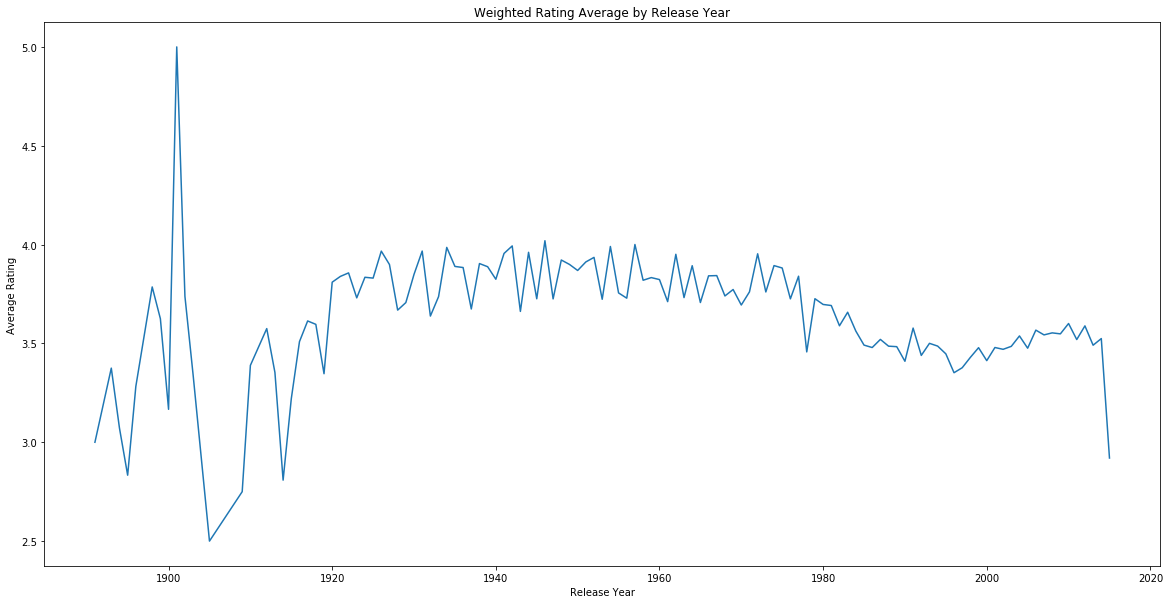

In [29]:
# Calculate weighted rating average
weight_rating_avg = avg_movie_rating.groupby('releaseYear').apply(lambda x: np.average(x.avg_movie_rating, weights=x.movie_ratings)).reset_index()
weight_rating_avg.columns = ['releaseYear', 'weighted_rating']

# Plot the results
sns.lineplot(x='releaseYear', y='weighted_rating', data=weight_rating_avg)
_ = plt.xlabel('Release Year')
_ = plt.ylabel('Average Rating')
_ = plt.title('Weighted Rating Average by Release Year')
plt.show()

As movies, and technology, have advanced, movies became more sophisticated and better, clearly seeing a golden age of cinema between the 40s and 70s, when the best movies were made, according to the users. But, as the 80s started, there has been a decline in movie quality, with the average movie rating going from 4.0 in the 1960s to 3.5 in 2010. Though not a drastic change, still one to consider. 
On the other hand, there have been more movies produced in recent years, and most movies are made to make a profit rather to produce content of quality, which could also explain this downturn in average rating. 

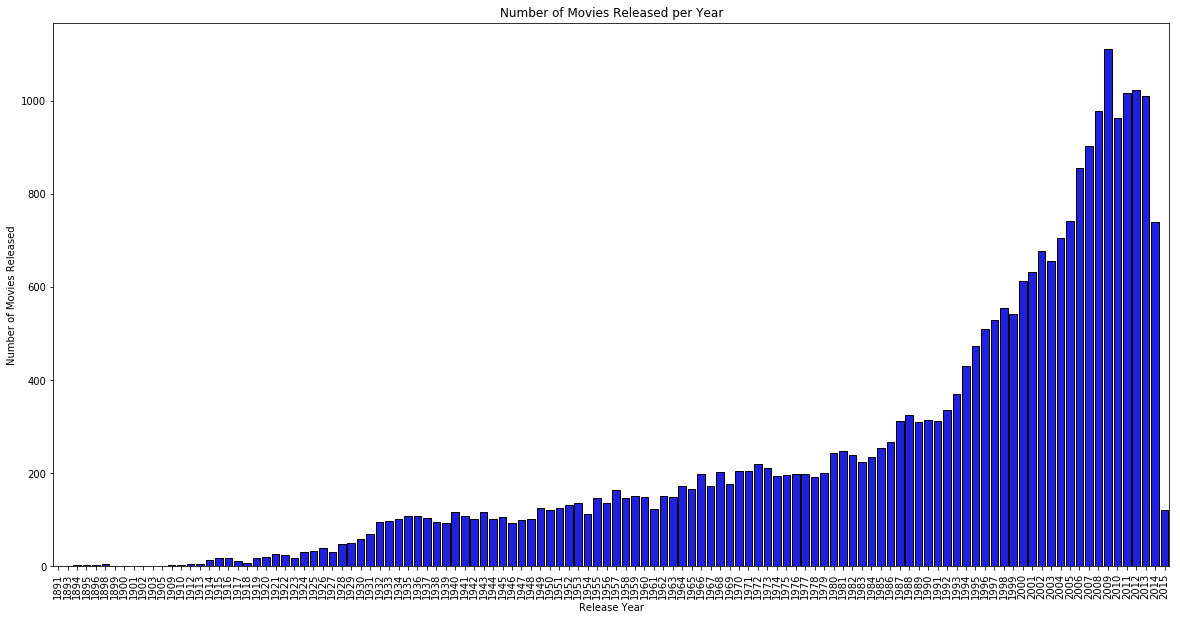

In [30]:
# Count movies per year
movie_count = movies.groupby('releaseYear')['movieId'].count().reset_index()
movie_count = movie_count[movie_count['releaseYear']>=1891]

sns.barplot(x='releaseYear', y='movieId', data=movie_count, color='blue')
_ = plt.xticks(rotation=90)
_ = plt.xlabel('Release Year')
_ = plt.ylabel('Number of Movies Released')
_ = plt.title('Number of Movies Released per Year')
plt.show()

movie_count = None
weight_rating_avg = None
avg_movie_rating = None
weight_rating_avg = None

### Links  

Next, we will tackle the `links` data set. This dataframe only has three columns: `movieId`, `imdbid`, and `tmdbid`. The first column is our identifier, allowing us to link to the previous to data sets. The second and third columns contain the id number for the Internet Movie Database (IMDB) and The Movie Database (TMDB). These will be helpful should we decide to obtain additional information about the movies within these data. 

As with the other dataframes, we'll explore this data set and clean, if necessary.

In [31]:
# Print first 5 rows of links
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


Let's look at the table info.  

In [32]:
# linnks info
links.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 3 columns):
movieId    27278 non-null int64
imdbId     27278 non-null int64
tmdbId     27026 non-null float64
dtypes: float64(1), int64(2)
memory usage: 639.4 KB


Next, let's see if there are any null values.  It turns out there are, but only the `tmdbId` has null values.  This means if we want to look up the movies in the movie database, we will have to ensure we find a different method for those missing movies.  All of the movies in the table have an `imdbId`.  

In [33]:
# check for nulls
links.isnull().values.any()

True

In [34]:
links['imdbId'].isnull().values.any()

False

In [35]:
links['tmdbId'].isnull().values.any()

True

In total, there are 252 records in the `links` dataframe that do not have `tmdbId` number.  

In [36]:
print(links['tmdbId'].isnull().values.sum())

print(links[links['tmdbId'].isnull()].head())

252
     movieId  imdbId  tmdbId
140      142   94878     NaN
598      604  115978     NaN
708      720  118114     NaN
709      721  114103     NaN
718      730  125877     NaN


Given that these data points still have `imdbId` values, they will not be dropped, as they can still be useful when obtaining data from the IMDB website. 

### Tags  
Finally, we will explore the `tags` dataframe. Like `genres` in the `movies` dataframe, this one also features several `tags` associated to both users and movies. In other words, each user can apply as many tags as they want to the movies they have seen. We'll work in the same fashion as the `movies` dataframe, converting the `tag` column into a sparse matrix. First, let's look at the first five observatios of the dataframe. Like the `ratings` dataframe, these data also have a timestamp that will need to be cleaned.

In [37]:
tags['tag'] = tags['tag'].str.lower()

In [38]:
tags.head()

,userId,movieId,tag,timestamp
0,18,4141,mark waters,1240597180
1,65,208,dark hero,1368150078
2,65,353,dark hero,1368150079
3,65,521,noir thriller,1368149983
4,65,592,dark hero,1368150078


Let's look at the dataframe's info and check for nulls prior to fixing the timestamp.  

In [39]:
tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 465564 entries, 0 to 465563
Data columns (total 4 columns):
userId       465564 non-null int64
movieId      465564 non-null int64
tag          465548 non-null object
timestamp    465564 non-null int64
dtypes: int64(3), object(1)
memory usage: 14.2+ MB


There are some null values in the dataframe.  Let's see which columns contain nulls.  

In [40]:
tags.isnull().values.any()

True

In [41]:
tags['userId'].isnull().values.any()

False

In [42]:
tags['movieId'].isnull().values.any()

False

In [43]:
tags['tag'].isnull().values.any()

True

In [44]:
tags['timestamp'].isnull().values.any()

False

It appears as though there are null values in the `tag` column; since a all movies should have a tag, null values will be dropped from the dataframe.

In [45]:
tags = tags.dropna()

Now, we can address the `timestamp`.  We will use the same technique as described in the `user` data exploration section. First, we will create a column named `tageDateTime`.  

In [46]:
tags['tagDateTime'] = datetime.strptime('Jan 1 1970 12:00AM', '%b %d %Y %I:%M%p') + pd.to_timedelta(tags.timestamp, 's')

Then, we can create the `tagYear` from `tagDateTime`.  

In [47]:
tags['tagYear'] = pd.DatetimeIndex(tags['tagDateTime']).year

Like we did with the movies dataframe, one thing that we also wanted to check was how tag used evolved over time, not over the year that the tag was applied but the year the movie was released. We'll create a merged tag_movie dataframe to explore this.

In [48]:
# So as not to lose our data, we'll again copy the tags dataframe to a new tag_evolution dataframe and work from there. 
tag_evolution = tags

# We now want to clean the tags, removing special characters and applying lower to have all letters as lowercase. This will help us better group together the tags. 
tag_evolution['tag'] = tag_evolution['tag'].astype(str)
tag_evolution['tag'] = tag_evolution['tag'].map(lambda x: re.sub(r'\W', ' ', x).lower())
tag_evolution.head()

,userId,movieId,tag,timestamp,tagDateTime,tagYear
0,18,4141,mark waters,1240597180,2009-04-24 18:19:40,2009
1,65,208,dark hero,1368150078,2013-05-10 01:41:18,2013
2,65,353,dark hero,1368150079,2013-05-10 01:41:19,2013
3,65,521,noir thriller,1368149983,2013-05-10 01:39:43,2013
4,65,592,dark hero,1368150078,2013-05-10 01:41:18,2013


The tag_evolution dataframe needs to be merged with the movies dataframe to get the year each movie was released. 

In [49]:
# Merge dataframes tag_evolution and movies
tag_evolution['movieId'] = tag_evolution['movieId'].astype(object)
tag_movies = tag_evolution.merge(movies, on="movieId", how="left")

# We only care about the movieId, releaseYear, and tags, so we'll keep those columns and drop the rest. 
tag_movies = tag_movies[['movieId', 'releaseYear', 'tag']]
tag_movies.head()

,movieId,releaseYear,tag
0,4141,2001,mark waters
1,208,1995,dark hero
2,353,1994,dark hero
3,521,1993,noir thriller
4,592,1989,dark hero


The tags may be in lowercase and special characters have been removed, but the text still needs some cleaning since we have tags that reference the same object but both as plural and singular (i.e zombie and zombies). Using NLTK's PorterStemmer, we'll stem the tags to get a more reduced list. 

In [50]:
# Initialize stemmer
porter = PorterStemmer()


# Create function that tokenizes words in string and stems words. 
def stemSentence(sentence):
    token_words=word_tokenize(sentence)
    token_words
    stem_sentence=[]
    for word in token_words:
        stem_sentence.append(porter.stem(word))
        stem_sentence.append(" ")
    return "".join(stem_sentence)

# Stem clean text in df_clean
tag_movies['tag'] = tag_movies['tag'].map(lambda x: str(stemSentence(x)))
tag_movies.head()

,movieId,releaseYear,tag
0,4141,2001,mark water
1,208,1995,dark hero
2,353,1994,dark hero
3,521,1993,noir thriller
4,592,1989,dark hero


The data finally clean, we can count how many times each tag occurs over the years, getting a sense for how tags change over time. 

   index  releaseYear           tag  movieId
0    144         1893        short         1
1    145         1894    dvd video         1
2    146         1894        short         1
3    147         1895  loui lumièr         2
4    148         1895   short film         1


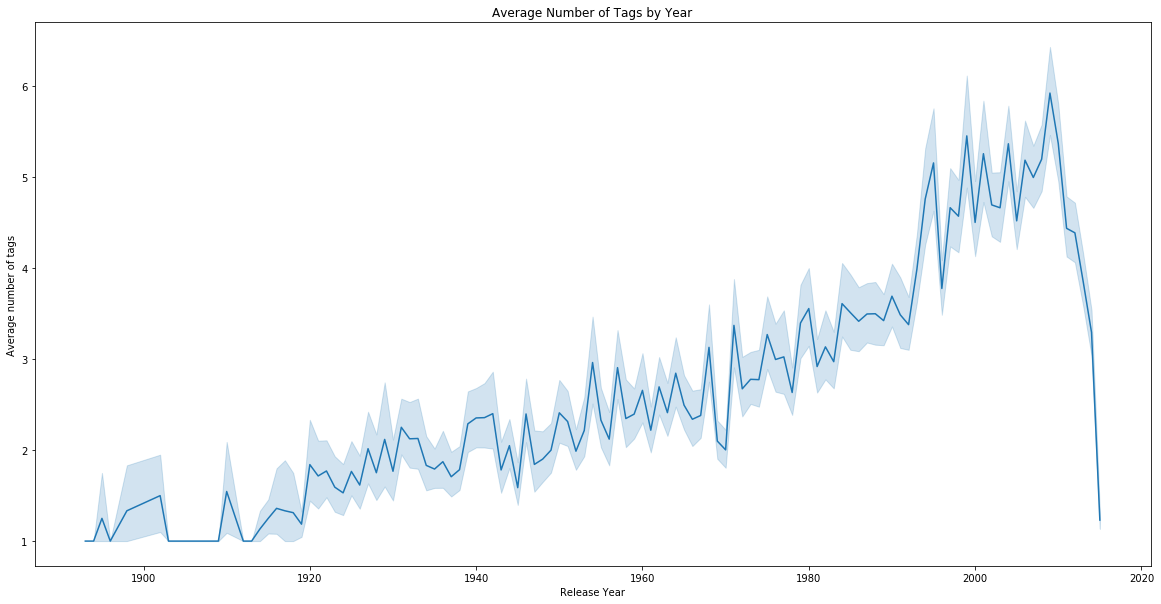

In [51]:
# Group tags by year and count the number of occurences
tag_year_counts = tag_movies.groupby(['releaseYear', 'tag'])['movieId'].count().reset_index()

# Drop movies that don't have a release year or release year is less than four digits
tag_year_counts = tag_year_counts[tag_year_counts['releaseYear']>=1891].reset_index()
print(tag_year_counts.head())

# Plot the number of tags by year
sns.lineplot(x='releaseYear', y='movieId', data=tag_year_counts)
_ = plt.xlabel('Release Year')
_ = plt.ylabel('Average number of tags')
_ = plt.title('Average Number of Tags by Year')
plt.show()

This is interesting as it tells us that more recent movies tend to have more tags, maybe because of the rise of new genres or more specific topics or ideas being expanded into movies. We'll focus on ten tags to see how these evolve over the same period. 

In [52]:
# Convert tags to string
for x in range(len(tag_year_counts)):
    tag_year_counts.loc[x, 'tag'] = str(tag_year_counts.loc[x, 'tag'])
    
tag_year_counts.head()

,index,releaseYear,tag,movieId
0,144,1893,short,1
1,145,1894,dvd video,1
2,146,1894,short,1
3,147,1895,loui lumièr,2
4,148,1895,short film,1


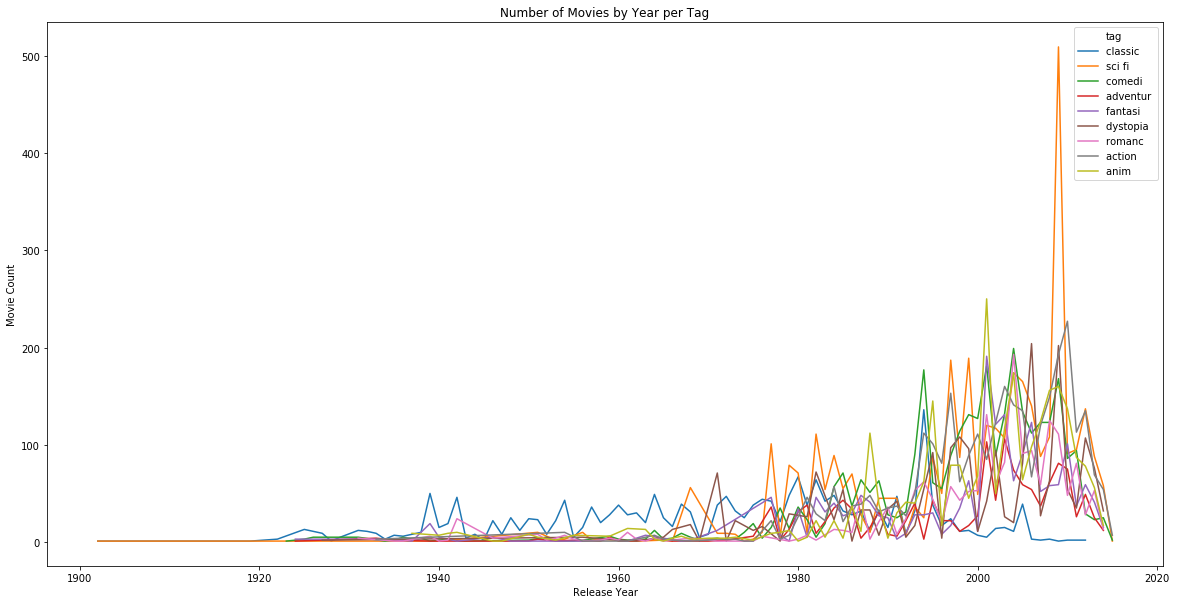

In [53]:
# Tags to be focused on 
tags_of_interest = ['comedi ', 'dystopia ', 'classic ', 'action ', 'sci fi ', 'romanc ', 'adventur ', 'anim ', 'fantasi ']

tags_final = tag_year_counts[tag_year_counts['tag'].isin(tags_of_interest)]

# Plot the tags
sns.lineplot(x='releaseYear', y='movieId', data=tags_final, hue='tag')
_ = plt.xlabel('Release Year')
_ = plt.ylabel('Movie Count')
_ = plt.title('Number of Movies by Year per Tag')
plt.show()

We can see that, when movies started, animated movies weren't that popular. But, with the rise of Disney, we can see animated movies start to take off around 1960 and are currently seeing arond 200 animated movies per year over the last 20 years. We can also see that Sci-Fi movies have seen a massive rise compared to the seventies and eightes, while classics come few and far between.  

Now, before moving on, we shoud count the frequency with which tags appear in the data set. 

In [54]:
# Calculate number of times each tag is mentioned. 
tags['counts'] = tags.groupby(['tag'])['movieId'].transform('count')
#tag_counts = tags.groupby(['tag'])['movieId'].count().reset_index().sort_values('movieId', ascending=False)

# Print tag_count shapes
print(tags['counts'].unique().shape[0])

500


There are over 35,000 unique tags in the dataset. Those are too many tags to work with and most of them only appear once. Given that we want to work with a number of tags that are significant, we will keep only those tags that appear at least 1,000 times within the dataset. 

In [55]:
tags = tags[tags['counts'] >= 1000]

In [56]:
tags.head()

,userId,movieId,tag,timestamp,tagDateTime,tagYear,counts
28,65,48082,surreal,1304958354,2011-05-09 16:25:54,2011,2528
35,96,106696,animation,1396097490,2014-03-29 12:51:30,2014,1345
41,96,106696,music,1396097508,2014-03-29 12:51:48,2014,1000
51,121,778,dark comedy,1300852846,2011-03-23 04:00:46,2011,1910
52,121,778,drugs,1300852844,2011-03-23 04:00:44,2011,1336


Now, we can unstak the  `tags` where we will show the year a tag was used by a user on a given movie.  The value for each `tag` will be the `tagYear`.  

In [57]:
tags_unstack = tags.groupby(['userId', 'movieId', 'tag'])['tagYear'].first().unstack('tag').reset_index()
tags = tags_unstack.fillna(0)
tags_unstack = None
tags.head()

tag,userId,movieId,action,adventure,aliens,animation,atmospheric,based on a book,bd r,betamax,...,surreal,tense,thought provoking,thriller,time travel,true story,twist ending,violence,visually appealing,world war ii
0,65,48082,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2011.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,96,106696,0.0,0.0,0.0,2014.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,121,778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,121,1288,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,121,2706,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Similar to the `genresMatrix` above, we will now create a `tagsMatrix`.  This time, however, instead of flagging each entry with a 0 or a 1, we will use the year the tag was used to identify the tag's presence for a given move, and a 0 otherwise.  

In [58]:
tagsMatrix = []

for i in range(tags.shape[0]):
    tagsMatrix.append(list(tags.iloc[i, 2:]))
    
tags = tags[['userId', 'movieId']]
tags['tagsMatrix'] = tagsMatrix
tagsMatrix = None
tags.head()

tag,userId,movieId,tagsMatrix
0,65,48082,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,96,106696,"[0.0, 0.0, 0.0, 2014.0, 0.0, 0.0, 0.0, 0.0, 0...."
2,121,778,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,121,1288,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,121,2706,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


### Combine Data  

Having explored the datasets and cleaned them accordingly, we will now combine the data.

In [59]:
# Convert movieId in links and tags to objects
links['movieId'] = links.movieId.astype(object)
tags['movieId'] = tags.movieId.astype(object)
tags['userId'] = tags.userId.astype(object)

ml = pd.merge(movies, ratings, on = 'movieId', how = 'inner')
ml = pd.merge(ml, links, on = 'movieId', how = 'inner')
ml = pd.merge(ml, tags, on = ['movieId', 'userId'], how = 'inner')
ml.head()

,movieId,title,releaseYear,decade,g1,g2,g3,g4,g5,g6,...,userId,rating,ratingDateTime,ratingDate,ratingYear,ratingMonth,ratingDay,imdbId,tmdbId,tagsMatrix
0,1,Toy Story,1995,1990,Adventure,Animation,Children,Comedy,Fantasy,NaN,...,3596,1.0,2010-11-21 04:00:52,2010-11-21,2010,11,21,114709,862.0,"[0.0, 0.0, 0.0, 2010.0, 0.0, 0.0, 0.0, 0.0, 0...."
1,1,Toy Story,1995,1990,Adventure,Animation,Children,Comedy,Fantasy,NaN,...,10616,3.5,2010-06-24 05:25:56,2010-06-24,2010,6,24,114709,862.0,"[0.0, 2010.0, 0.0, 2010.0, 0.0, 0.0, 0.0, 0.0,..."
2,1,Toy Story,1995,1990,Adventure,Animation,Children,Comedy,Fantasy,NaN,...,11355,4.0,2012-11-29 02:02:39,2012-11-29,2012,11,29,114709,862.0,"[0.0, 0.0, 0.0, 2012.0, 0.0, 0.0, 0.0, 0.0, 0...."
3,1,Toy Story,1995,1990,Adventure,Animation,Children,Comedy,Fantasy,NaN,...,11621,4.0,2006-07-07 07:41:09,2006-07-07,2006,7,7,114709,862.0,"[0.0, 0.0, 0.0, 2006.0, 0.0, 0.0, 0.0, 0.0, 0...."
4,1,Toy Story,1995,1990,Adventure,Animation,Children,Comedy,Fantasy,NaN,...,18390,5.0,2006-07-10 22:46:50,2006-07-10,2006,7,10,114709,862.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [60]:
ml.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44881 entries, 0 to 44880
Data columns (total 25 columns):
movieId           44881 non-null object
title             44881 non-null object
releaseYear       44881 non-null int64
decade            44881 non-null object
g1                44881 non-null object
g2                39505 non-null object
g3                27667 non-null object
g4                12569 non-null object
g5                3695 non-null object
g6                845 non-null object
g7                292 non-null object
g8                2 non-null object
g9                2 non-null object
g10               2 non-null object
genresMatrix      44881 non-null object
userId            44881 non-null object
rating            44881 non-null float64
ratingDateTime    44881 non-null datetime64[ns]
ratingDate        44881 non-null object
ratingYear        44881 non-null object
ratingMonth       44881 non-null int64
ratingDay         44881 non-null int64
imdbId            4488

## Recommendation System 1: User Based

In [61]:
# Create user/movie rating table
user_movie = ml[['userId', 'movieId', 'rating']]
user_movie = user_movie[user_movie.rating > 4]
user_movie = user_movie.pivot_table(index = 'userId', columns = 'movieId', values = 'rating').fillna(0)

In [62]:
# Randomize sample
user_movie = user_movie.sample(user_movie.shape[0], random_state = 2500)
train_percentage = 0.5

In [63]:
user_movie.shape

(2894, 3120)

In [64]:
train = user_movie.iloc[0:int(train_percentage*user_movie.shape[0])]
train.shape

(1447, 3120)

In [65]:
test = user_movie.iloc[int(train_percentage*user_movie.shape[0]):]
test.shape

(1447, 3120)

In [66]:
train.head()

movieId,1,2,6,7,10,16,17,18,19,21,...,119065,119145,119655,120134,127098,128600,128734,128738,128981,128991
userId,,,,,,,,,,,,,,,,,,,,,
92475,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
105707,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32964,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
62396,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
62716,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [67]:
# Movie recommendation function
def recommendations(userId, loss_fn, n_watched = 10, n_recommended = 5):
    
    # Get number of users and number of items from train data
    n_users, n_items = train.shape
    
    # Create lightfm model
    LFM_model = LightFM(loss = loss_fn)

    # Fit/train model
    LFM_model.fit(sp.sparse.csr_matrix(train), epochs = 100, num_threads = 5)
    
    for user in userId:
       
        scores = LFM_model.predict(user, np.arange(n_items))
       
        try:
            known_movies = train.loc[user, :]
            known_movies = known_movies[known_movies != 0].reset_index().head(n_watched)
 
            results = pd.DataFrame({'Title': list(train), 'Score': scores}).sort_values(by = 'Score', ascending = False)
 
            recommendation = results['Title'].head(n_recommended)
    
            rec_matrix = (userId, list(known_movies.movieId), list(recommendation))
            
            #return((userId, list(known_movies.movieId), list(recommendation)))
            
            # Recommendations with TMDB Data
            print('User {} has watched the following movie(s):\n'.format(rec_matrix[0][0]))
            watched = pd.DataFrame(list(rec_matrix[1]), columns = ['movieId']).astype(object)
            watched = pd.merge(watched, links, on = 'movieId', how = 'inner')
    
            for movie in watched.tmdbId:
                print('{}'.format(tmdb.Movies(int(movie)).info()['title']))
        
            print('\n')
    
            print('Based on previous movies watched, we recommend the following:\n')
            recommended = pd.DataFrame(list(rec_matrix[2]), columns = ['movieId']).astype(object)
            recommended = pd.merge(recommended, links, on = 'movieId', how = 'inner')

            try: 
                for movie in recommended.tmdbId:
                    movie_info = tmdb.Movies(int(movie)).info()
                    display(Image(url = 'http://image.tmdb.org/t/p/w185/{}'.format(movie_info['poster_path']), embed = True))
                    print('TMDB Link: https://www.themoviedb.org/movie/{}'.format(int(movie)))
                    print('Name: {}'.format(movie_info['title']))
                    genres = []
                    for genre in movie_info['genres']:
                        genres.append(genre['name'])

                    print('Genre(s): {}'.format(', '.join(genres)))
                    print('Release Date: {}'.format(movie_info['release_date']))
                    print('Average TMDB Rating: {}'.format(movie_info['vote_average']))
                    print('Adult Rating: {}'.format('Yes' if movie_info['adult'] else 'No'))
                    print('Description: {}'.format(movie_info['overview']))

                    print('\n')
            except:
                print('No TMDB data listed for this movie.')
            
            try: 
                test_precision = precision_at_k(LFM_model, sp.sparse.csr_matrix(test), k = 2).mean()
                print('Model Precision: {:.2f}%'.format(test_precision * 100))
            except:
                print('Error with precision calculation.  ')
            
        except:
            print('Please try again.  Ensure the userId variable is a list of integers')

User 121 has watched the following movie(s):

This Is Spinal Tap
American Pie
American Pie 2
National Lampoon's Van Wilder
Old School
The 40 Year Old Virgin
Lord of War
Knocked Up
Step Brothers


Based on previous movies watched, we recommend the following:



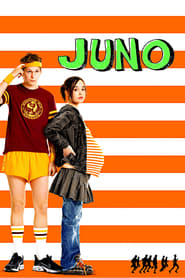

TMDB Link: https://www.themoviedb.org/movie/7326
Name: Juno
Genre(s): Comedy, Drama, Romance
Release Date: 2007-12-05
Average TMDB Rating: 7.0
Adult Rating: No
Description: A young girl named Juno gets herself pregnant and tries to stand on her own, but soon learns a few lessons about being grown up.




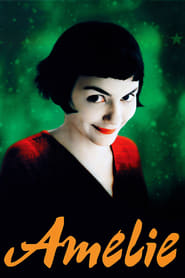

TMDB Link: https://www.themoviedb.org/movie/194
Name: Amélie
Genre(s): Comedy, Romance
Release Date: 2001-04-25
Average TMDB Rating: 7.9
Adult Rating: No
Description: At a tiny Parisian café, the adorable yet painfully shy Amélie (Audrey Tautou) accidentally discovers a gift for helping others. Soon Amelie is spending her days as a matchmaker, guardian angel, and all-around do-gooder. But when she bumps into a handsome stranger, will she find the courage to become the star of her very own love story?




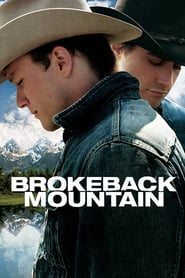

TMDB Link: https://www.themoviedb.org/movie/142
Name: Brokeback Mountain
Genre(s): Drama, Romance
Release Date: 2005-09-10
Average TMDB Rating: 7.8
Adult Rating: No
Description: Two modern-day cowboys meet on a shepherding job in the summer of '63, the two share a raw and powerful summer together that turns into a lifelong relationship conflicting with the lives they are supposed to live.




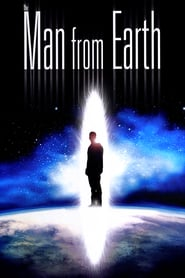

TMDB Link: https://www.themoviedb.org/movie/13363
Name: The Man from Earth
Genre(s): Science Fiction, Drama
Release Date: 2007-06-10
Average TMDB Rating: 7.7
Adult Rating: No
Description: An impromptu goodbye party for Professor John Oldman becomes a mysterious interrogation after the retiring scholar reveals to his colleagues he never ages and has walked the earth for 14,000 years.




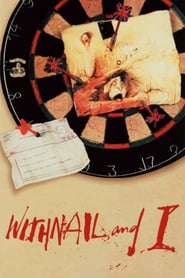

TMDB Link: https://www.themoviedb.org/movie/13446
Name: Withnail & I
Genre(s): Comedy, Drama
Release Date: 1987-06-19
Average TMDB Rating: 7.4
Adult Rating: No
Description: Two out-of-work actors -- the anxious, luckless Marwood and his acerbic, alcoholic friend, Withnail -- spend their days drifting between their squalid flat, the unemployment office and the pub. When they take a holiday "by mistake" at the country house of Withnail's flamboyantly gay uncle, Monty, they encounter the unpleasant side of the English countryside: tedium, terrifying locals and torrential rain.


Model Precision: 2.25%


In [68]:
recommendations([121], 'bpr')

User 121 has watched the following movie(s):

This Is Spinal Tap
American Pie
American Pie 2
National Lampoon's Van Wilder
Old School
The 40 Year Old Virgin
Lord of War
Knocked Up
Step Brothers


Based on previous movies watched, we recommend the following:



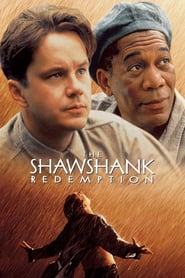

TMDB Link: https://www.themoviedb.org/movie/278
Name: The Shawshank Redemption
Genre(s): Drama, Crime
Release Date: 1994-09-23
Average TMDB Rating: 8.7
Adult Rating: No
Description: Framed in the 1940s for the double murder of his wife and her lover, upstanding banker Andy Dufresne begins a new life at the Shawshank prison, where he puts his accounting skills to work for an amoral warden. During his long stretch in prison, Dufresne comes to be admired by the other inmates -- including an older prisoner named Red -- for his integrity and unquenchable sense of hope.




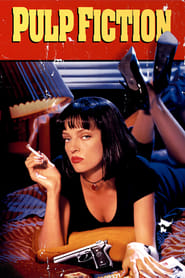

TMDB Link: https://www.themoviedb.org/movie/680
Name: Pulp Fiction
Genre(s): Thriller, Crime
Release Date: 1994-09-10
Average TMDB Rating: 8.4
Adult Rating: No
Description: A burger-loving hit man, his philosophical partner, a drug-addled gangster's moll and a washed-up boxer converge in this sprawling, comedic crime caper. Their adventures unfurl in three stories that ingeniously trip back and forth in time.




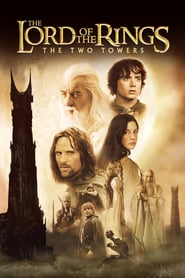

TMDB Link: https://www.themoviedb.org/movie/121
Name: The Lord of the Rings: The Two Towers
Genre(s): Adventure, Fantasy, Action
Release Date: 2002-12-18
Average TMDB Rating: 8.2
Adult Rating: No
Description: Frodo and Sam are trekking to Mordor to destroy the One Ring of Power while Gimli, Legolas and Aragorn search for the orc-captured Merry and Pippin. All along, nefarious wizard Saruman awaits the Fellowship members at the Orthanc Tower in Isengard.




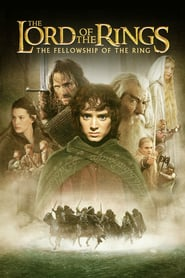

TMDB Link: https://www.themoviedb.org/movie/120
Name: The Lord of the Rings: The Fellowship of the Ring
Genre(s): Adventure, Fantasy, Action
Release Date: 2001-12-18
Average TMDB Rating: 8.3
Adult Rating: No
Description: Young hobbit Frodo Baggins, after inheriting a mysterious ring from his uncle Bilbo, must leave his home in order to keep it from falling into the hands of its evil creator. Along the way, a fellowship is formed to protect the ringbearer and make sure that the ring arrives at its final destination: Mt. Doom, the only place where it can be destroyed.




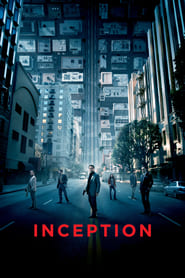

TMDB Link: https://www.themoviedb.org/movie/27205
Name: Inception
Genre(s): Action, Science Fiction, Adventure
Release Date: 2010-07-15
Average TMDB Rating: 8.3
Adult Rating: No
Description: Cobb, a skilled thief who commits corporate espionage by infiltrating the subconscious of his targets is offered a chance to regain his old life as payment for a task considered to be impossible: "inception", the implantation of another person's idea into a target's subconscious.


Model Precision: 2.97%


In [69]:
recommendations([121], 'warp')

User 129 has watched the following movie(s):

Donnie Darko


Based on previous movies watched, we recommend the following:



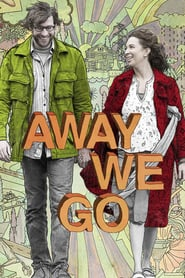

TMDB Link: https://www.themoviedb.org/movie/19255
Name: Away We Go
Genre(s): Comedy, Drama, Romance
Release Date: 2009-06-05
Average TMDB Rating: 6.8
Adult Rating: No
Description: Verona and Burt have moved to Colorado to be close to Burt's parents but, with Veronica expecting their first child, Burt's parents decide to move to Belgium, now leaving them in a place they hate and without a support structure in place. They set off on a whirlwind tour of of disparate locations where they have friends or relatives, sampling not only different cities and climates but also different families. Along the way they realize that the journey is less about discovering where they want to live and more about figuring out what type of parents they want to be.




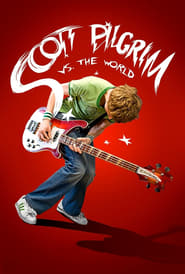

TMDB Link: https://www.themoviedb.org/movie/22538
Name: Scott Pilgrim vs. the World
Genre(s): Action, Comedy, Romance
Release Date: 2010-07-27
Average TMDB Rating: 7.3
Adult Rating: No
Description: Scott Pilgrim is a 23 year old radical Canadian gamer and wannabe rockstar who falls in love with an American delivery girl, Ramona Flowers, and must defeat her seven evil exes to be able to date her.




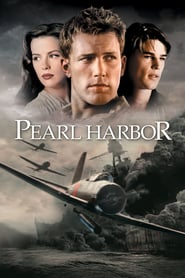

TMDB Link: https://www.themoviedb.org/movie/676
Name: Pearl Harbor
Genre(s): History, Romance, War, Drama
Release Date: 2001-05-21
Average TMDB Rating: 6.8
Adult Rating: No
Description: The lifelong friendship between Rafe McCawley and Danny Walker is put to the ultimate test when the two ace fighter pilots become entangled in a love triangle with beautiful Naval nurse Evelyn Johnson. But the rivalry between the friends-turned-foes is immediately put on hold when they find themselves at the center of Japan's devastating attack on Pearl Harbor on Dec. 7, 1941.




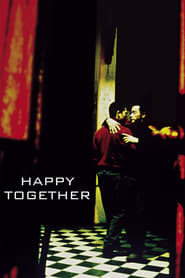

TMDB Link: https://www.themoviedb.org/movie/18329
Name: Happy Together
Genre(s): Drama, Romance
Release Date: 1997-05-17
Average TMDB Rating: 7.8
Adult Rating: No
Description: A couple take a trip to Argentina in search of a new beginning, but instead find themselves drifting ever further apart.




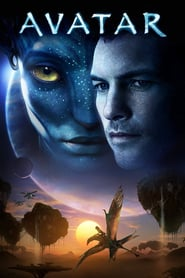

TMDB Link: https://www.themoviedb.org/movie/19995
Name: Avatar
Genre(s): Action, Adventure, Fantasy, Science Fiction
Release Date: 2009-12-10
Average TMDB Rating: 7.4
Adult Rating: No
Description: In the 22nd century, a paraplegic Marine is dispatched to the moon Pandora on a unique mission, but becomes torn between following orders and protecting an alien civilization.


Model Precision: 3.08%


In [91]:
recommendations([129], 'warp')

## Recommendation System 2: Movie Based

The first model received a user ID and returned a list of movies that would be recommended for that user basde on movies watched. Subjectively, some of those movies may not make sense: an individual may not want to go from Step Brothers to Brokeback Mountain (brp) or Lord of the Rings.

This model receives a movie ID as input and returns movies that are related based weights provided by the coders. This algorithm is courtesy of [Movie recommendation algorithm](https://www.kaggle.com/bakostamas/movie-recommendation-algorithm).

In [71]:
#Aggregate the movie ratings by the movie.
movieRatingsAggr = ratings.groupby(['movieId']).agg({'rating': [np.size, np.mean]})
movieRatingsAggr.reset_index(inplace=True)

#Combine the aggregate data frame with the movie data frame.
movies2 = movies2.merge(movieRatingsAggr, left_on='movieId', right_on='movieId', how='left')  # ['rating']
movies2 =movies2.rename(columns = {('rating', 'size'):'rating_count', ('rating', 'mean'):'rating_avg'} )

In [72]:
#Extract the year from the title.

def getYear(title):
    result = re.search(r'\(\d{4}\)', title)
    if result:
        found = result.group(0).strip('(').strip(')')
    else: 
        found = 0
    return int(found)
    
movies2['year'] = movies2.apply(lambda x: getYear(x['title']), axis=1)

In [73]:
#Like before, create a matrix of the genre list using one hot encoding.

genresList = [
  "Action",
  "Adventure",
  "Animation",
  "Children",
  "Comedy",
  "Crime",
  "Documentary",
  "Drama",
  "Fantasy",
  "Film-Noir",
  "Horror",
  "Musical",
  "Mystery",
  "Romance",
  "Sci-Fi",
  "Thriller",
  "War",
  "Western",
  "(no genres listed)"
]

def setGenresMatrix(genres):
    movieGenresMatrix = []
    movieGenresList = genres.split('|')
    for x in genresList:
        if (x in movieGenresList):
            movieGenresMatrix.append(1)
        else:
            movieGenresMatrix.append(0) 
    return movieGenresMatrix
    
movies2['genresMatrix'] = movies2.apply(lambda x: np.array(list(setGenresMatrix(x['genres']))), axis=1)

In [74]:
#Create a ratings group column that will act as a sort of popularity metric for this algorithm.

def setRatingGroup(numberOfRatings):
    # if (numberOfRatings is None): return 0
    if (1 <= numberOfRatings <= 10): return 1
    elif (11 <= numberOfRatings <= 30): return 2
    elif (31 <= numberOfRatings <= 100): return 3
    elif (101 <= numberOfRatings <= 300): return 4
    elif (301 <= numberOfRatings <= 1000): return 5
    elif (1001 <= numberOfRatings): return 6
    else: return 0

movies2['ratingGroup'] = movies2.apply(lambda x: setRatingGroup(x['rating_count']), axis=1)
movies2.fillna(0, inplace=True)  # Replace NaN values to zero

In [75]:
#Taking a slightly different approach to stemmer, this function will iterate through all the tags to find the important words and place them in a dictionary.

stopWords = ['a', 'about', 'above', 'above', 'across', 'after', 'afterwards', 'again', 'against', 'all', 'almost', 
        'alone', 'along', 'already', 'also','although','always','am','among', 'amongst', 'amoungst', 'amount',  'an', 'and', 
        'another', 'any','anyhow','anyone','anything','anyway', 'anywhere', 'are', 'around', 'as',  'at', 'back','be','became', 
        'because','become','becomes', 'becoming', 'been', 'before', 'beforehand', 'behind', 'being', 'below', 'beside', 'besides', 
        'between', 'beyond', 'bill', 'both', 'bottom','but', 'by', 'call', 'can', 'cannot', 'cant', 'co', 'con', 'could', 'couldnt', 
        'cry', 'de', 'describe', 'detail', 'do', 'done', 'down', 'due', 'during', 'each', 'eg', 'eight', 'either', 'eleven','else', 
        'elsewhere', 'empty', 'enough', 'etc', 'even', 'ever', 'every', 'everyone', 'everything', 'everywhere', 'except', 'few', 'fifteen', 
        'fify', 'fill', 'find', 'fire', 'first', 'five', 'for', 'former', 'formerly', 'forty', 'found', 'four', 'from', 'front', 'full', 
        'further', 'get', 'give', 'go', 'had', 'has', 'hasnt', 'have', 'he', 'hence', 'her', 'here', 'hereafter', 'hereby', 'herein', 'hereupon', 
        'hers', 'herself', 'him', 'himself', 'his', 'how', 'however', 'hundred', 'ie', 'if', 'in', 'inc', 'indeed', 'interest', 'into', 'is', 'it', 
        'its', 'itself', 'keep', 'last', 'latter', 'latterly', 'least', 'less', 'ltd', 'made', 'many', 'may', 'me', 'meanwhile', 'might', 'mill', 
        'mine', 'more', 'moreover', 'most', 'mostly', 'move', 'much', 'must', 'my', 'myself', 'name', 'namely', 'neither', 'never', 'nevertheless', 
        'next', 'nine', 'no', 'nobody', 'none', 'noone', 'nor', 'not', 'nothing', 'now', 'nowhere', 'of', 'off', 'often', 'on', 'once', 'one', 
        'only', 'onto', 'or', 'other', 'others', 'otherwise', 'our', 'ours', 'ourselves', 'out', 'over', 'own','part', 'per', 'perhaps', 'please', 
        'put', 'rather', 're', 'same', 'see', 'seem', 'seemed', 'seeming', 'seems', 'serious', 'several', 'she', 'should', 'show', 'side', 'since', 
        'sincere', 'six', 'sixty', 'so', 'some', 'somehow', 'someone', 'something', 'sometime', 'sometimes', 'somewhere', 'still', 'such', 'system', 
        'take', 'ten', 'than', 'that', 'the', 'their', 'them', 'themselves', 'then', 'thence', 'there', 'thereafter', 'thereby', 'therefore', 'therein', 
        'thereupon', 'these', 'they', 'thickv', 'thin', 'third', 'this', 'those', 'though', 'three', 'through', 'throughout', 'thru', 'thus', 'to', 
        'together', 'too', 'top', 'toward', 'towards', 'twelve', 'twenty', 'two', 'un', 'under', 'until', 'up', 'upon', 'us', 'very', 'via', 'was', 
        'we', 'well', 'were', 'what', 'whatever', 'when', 'whence', 'whenever', 'where', 'whereafter', 'whereas', 'whereby', 'wherein', 'whereupon', 
        'wherever', 'whether', 'which', 'while', 'whither', 'who', 'whoever', 'whole', 'whom', 'whose', 'why', 'will', 'with', 'within', 'without', 'would', 
        'yet', 'you', 'your', 'yours', 'yourself', 'yourselves', 'the']

tagsDict = {}

for index, x in tags2.iterrows():
    wordlist = str(x['tag']).lower().split(' ')
    movieId = x['movieId']
    for y in wordlist:
        if y not in stopWords:
            if movieId in tagsDict:
                # if y not in tagsDict[movieId]:  # Switched off (we will get a non unique list)
                    tagsDict[movieId].append(y)
            else:
                tagsDict[movieId] = [y]

In [76]:
#This function does the same thing but with movie titles.

titleWordsDict = {}

for index, x in movies2.iterrows():
    wordlist = str(x['title']).lower().split(' ')
    movieId = x['movieId']
    for y in wordlist:
        if y not in stopWords:
            if movieId in titleWordsDict:
                    titleWordsDict[movieId].append(y)
            else:
                titleWordsDict[movieId] = [y]

This next function receives a movieID as an input and computes its similarity with other movies given the weights we attribute.

In [77]:
# Parameter weights
genresSimilarityWeight = 1
tagsSimilarityWeight = 1.5
titleSimilarityWeight = 0.8
ratingAvgWeight = 0.2
ratingGroupWeight = 0.005
yearDistanceWeight = 0.1

def tagsSimilarity(basisMovieID, checkedMovieID, checkType):    
    # The higher value is the more similar (from 0 to 1) 
    if checkType == 'tag':
        dictToCheck = tagsDict
    else:
        dictToCheck = titleWordsDict
        
    counter = 0
    if basisMovieID in dictToCheck: 
        basisTags = dictToCheck[basisMovieID]
        countAllTags = len(basisTags)
        basisTagsDict = {}
        for x in basisTags:
            if x in basisTagsDict:
                basisTagsDict[x] += 1
            else:
                basisTagsDict[x] = 1   
        
        for x in basisTagsDict:
            basisTagsDict[x] = basisTagsDict[x] / countAllTags
    else: return 0
    
    if checkedMovieID in dictToCheck: 
        checkedTags = dictToCheck[checkedMovieID]
        checkedTags = set(checkedTags) # Make the list unique
        checkedTags = list(checkedTags)
        
    else: return 0
    
    for x in basisTagsDict:
        if x in checkedTags: counter += basisTagsDict[x]
    return counter
    
def checkSimilarity(movieId):
    basisGenres = np.array(list(movies2[movies2['movieId'] == movieId]['genresMatrix']))
    basisYear = int(movies2[movies2['movieId'] == movieId]['year'])
    basisRatingAvg = movies2[movies2['movieId'] == movieId]['rating_avg']
    basisRatingGroup = movies2[movies2['movieId'] == movieId]['ratingGroup']
    
    moviesWithSim = movies2
    moviesWithSim['similarity'] = moviesWithSim.apply(lambda x: 
                                                      spatial.distance.cosine(x['genresMatrix'], basisGenres) * genresSimilarityWeight + 
                                                      - tagsSimilarity(movieId, x['movieId'], 'tag') * tagsSimilarityWeight +
                                                      - tagsSimilarity(movieId, x['movieId'], 'title') * titleSimilarityWeight +
                                                      abs(basisRatingAvg - x['rating_avg']) * ratingAvgWeight +
                                                      abs(basisRatingGroup - x['ratingGroup']) * ratingGroupWeight + 
                                                      abs(basisYear - x['year'])/100 * yearDistanceWeight
                                                     , axis=1)
    
    moviesWithSim = moviesWithSim.loc[(moviesWithSim.movieId != movieId)]
    return moviesWithSim[['movieId', 'title', 'genres', 'rating_count', 'rating_avg', 'similarity']].sort_values('similarity')

Given this movie-based referall model, what would someone who watched Step Brothers want to see?

In [78]:
# Step Brothers

similarityResult  = checkSimilarity(60756)
similarityResult.head(10)

,movieId,title,genres,rating_count,rating_avg,similarity
11168,46970,Talladega Nights: The Ballad of Ricky Bobby (2...,Action|Comedy,2352.0,3.200680,-1.039294
7958,8641,Anchorman: The Legend of Ron Burgundy (2004),Comedy,5258.0,3.492773,-0.818223
18629,92719,Tim and Eric's Billion Dollar Movie (2012),Comedy,41.0,2.426829,-0.758088
12469,58156,Semi-Pro (2008),Comedy,597.0,2.869347,-0.725175
4720,4816,Zoolander (2001),Comedy,7499.0,3.255634,-0.701474
13106,63131,Role Models (2008),Comedy,1930.0,3.626425,-0.675701
22344,107348,Anchorman 2: The Legend Continues (2013),Comedy,343.0,3.055394,-0.611551
12032,54503,Superbad (2007),Comedy,6670.0,3.786207,-0.590662
13262,64969,Yes Man (2008),Comedy,1863.0,3.456522,-0.553432
12691,59784,Kung Fu Panda (2008),Action|Animation|Children|Comedy|IMAX,4468.0,3.712847,-0.539667


In [79]:
# Lord of War

similarityResult  = checkSimilarity(36529)
similarityResult.head(10)

,movieId,title,genres,rating_count,rating_avg,similarity
12326,56788,Charlie Wilson's War (2007),Comedy|Drama|War,2074.0,3.689007,-0.603572
10687,41997,Munich (2005),Action|Crime|Drama|Thriller,4745.0,3.731718,-0.584506
9937,32587,Sin City (2005),Action|Crime|Film-Noir|Mystery|Thriller,15481.0,3.874201,-0.524205
10109,33437,Unleashed (Danny the Dog) (2005),Action|Crime|Drama|Thriller,1380.0,3.517029,-0.498600
10377,36517,"Constant Gardener, The (2005)",Drama|Thriller,3572.0,3.747060,-0.491279
5917,6016,City of God (Cidade de Deus) (2002),Action|Adventure|Crime|Drama|Thriller,12937.0,4.235410,-0.467036
2873,2959,Fight Club (1999),Action|Crime|Drama|Thriller,40106.0,4.227123,-0.388892
10562,40278,Jarhead (2005),Action|Drama|War,2987.0,3.486776,-0.369341
10432,37733,"History of Violence, A (2005)",Action|Crime|Drama|Thriller,3878.0,3.636668,-0.358465
11623,50944,S.P.L.: Kill Zone (Saat po long) (2005),Action|Crime|Drama|Thriller,27.0,3.833333,-0.322139


In [80]:
# Donnie Darko

similarityResult  = checkSimilarity(4878)
similarityResult.head(10)

,movieId,title,genres,rating_count,rating_avg,similarity
31,32,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller,44980.0,3.898055,-0.839483
15534,79132,Inception (2010),Action|Crime|Drama|Mystery|Sci-Fi|Thriller|IMAX,14023.0,4.156172,-0.803661
2873,2959,Fight Club (1999),Action|Crime|Drama|Thriller,40106.0,4.227123,-0.730773
1180,1206,"Clockwork Orange, A (1971)",Crime|Drama|Sci-Fi|Thriller,24694.0,3.995303,-0.614613
4752,4848,Mulholland Drive (2001),Crime|Drama|Film-Noir|Mystery|Thriller,9307.0,3.818524,-0.597996
7142,7254,The Butterfly Effect (2004),Drama|Sci-Fi|Thriller,8764.0,3.691522,-0.577427
4132,4226,Memento (2000),Mystery|Thriller,30443.0,4.178547,-0.534674
4879,4975,Vanilla Sky (2001),Mystery|Romance|Sci-Fi|Thriller,8318.0,3.371363,-0.520658
7249,7361,Eternal Sunshine of the Spotless Mind (2004),Drama|Romance|Sci-Fi,22352.0,4.105628,-0.509702
1684,1748,Dark City (1998),Adventure|Film-Noir|Sci-Fi|Thriller,11759.0,3.798877,-0.507328


## References  

"Comprehensive Guide to build a Recommendation Engine from scratch (in Python)", *Analytics Vidhya*, [https://www.analyticsvidhya.com/blog/2018/06/comprehensive-guide-recommendation-engine-python/](https://www.analyticsvidhya.com/blog/2018/06/comprehensive-guide-recommendation-engine-python/). Date accessed 18 March, 2019  

"Convert Pandas Column to DateTime", *Stack Overflow*, [https://stackoverflow.com/questions/26763344/convert-pandas-column-to-datetime](https://stackoverflow.com/questions/26763344/convert-pandas-column-to-datetime). Date accessed 10 February, 2019  

"Converting Strings to datetime in Python", *Stack Abuse*, [https://stackabuse.com/converting-strings-to-datetime-in-python/](https://stackabuse.com/converting-strings-to-datetime-in-python/). Date accessed 11 February, 2019  

"Count max occurence of character in pandas dataframe", *Stack Overflow*, [https://stackoverflow.com/questions/47362355/count-max-occurence-of-character-in-pandas-dataframe](https://stackoverflow.com/questions/47362355/count-max-occurence-of-character-in-pandas-dataframe). Date accessed 11 February, 2019

"Creating a Simple Recommender System in Python using Pandas", *Stack Abuse*, [https://stackabuse.com/creating-a-simple-recommender-system-in-python-using-pandas/](https://stackabuse.com/creating-a-simple-recommender-system-in-python-using-pandas/). Date accessed 12 February, 2019  

"Embedding image in ipython notebook for distribution", *Stack Overflow*, [https://stackoverflow.com/questions/26068316/embedding-image-in-ipython-notebook-for-distribution](https://stackoverflow.com/questions/26068316/embedding-image-in-ipython-notebook-for-distribution). Date accessed 24 March, 2019  

"Extracting just Month and Year fro Pandas Datetime column", *Stack Overflow*, [https://stackoverflow.com/questions/25146121/extracting-just-month-and-year-from-pandas-datetime-column](https://stackoverflow.com/questions/25146121/extracting-just-month-and-year-from-pandas-datetime-column). Date accessed 11 February, 2019

"Hide all warnings in python", *Stack Overflow*, [https://stackoverflow.com/questions/9031783/hide-all-warnings-in-ipython](https://stackoverflow.com/questions/9031783/hide-all-warnings-in-ipython). Date accessed 10 February, 2019  

"How do you change the size of figures drawn with matplotlib?", *Stack Overflow*, [https://stackoverflow.com/questions/332289/how-do-you-change-the-size-of-figures-drawn-with-matplotlib](https://stackoverflow.com/questions/332289/how-do-you-change-the-size-of-figures-drawn-with-matplotlib). Date accessed 07 February, 2019

"How do you check in python whether a string contains only numbers?", *Stack Overflow*, [https://stackoverflow.com/questions/21388541/how-do-you-check-in-python-whether-a-string-contains-only-numbers](https://stackoverflow.com/questions/21388541/how-do-you-check-in-python-whether-a-string-contains-only-numbers). Data accessed 11 February, 2019  

"Hot to build a Movie Recommender System in Python using LightFM", *Towards Data Science*, [https://towardsdatascience.com/how-to-build-a-movie-recommender-system-in-python-using-lightfm-8fa49d7cbe3b](https://towardsdatascience.com/how-to-build-a-movie-recommender-system-in-python-using-lightfm-8fa49d7cbe3b). Date accessed 19 March, 2019  

"How to change dataframe column names in pyspark?", *Stack Overflow", [https://stackoverflow.com/questions/34077353/how-to-change-dataframe-column-names-in-pyspark](https://stackoverflow.com/questions/34077353/how-to-change-dataframe-column-names-in-pyspark). Date accessed 08 February, 2019

"How to split a column into two columns?", *Stack Overflow*, [https://stackoverflow.com/questions/14745022/how-to-split-a-column-into-two-columns](https://stackoverflow.com/questions/14745022/how-to-split-a-column-into-two-columns). Date accessed 10 February, 2019 

"I want to create a column of value_counts in my pandas dataframe", *Stack Overflow@ [https://stackoverflow.com/questions/17709270/i-want-to-create-a-column-of-value-counts-in-my-pandas-dataframe](https://stackoverflow.com/questions/17709270/i-want-to-create-a-column-of-value-counts-in-my-pandas-dataframe). Date accessed 16 February, 2019  

"Movie Recommendation Algorithm", *Kaggle*, [https://www.kaggle.com/bakostamas/movie-recommendation-algorithm](https://www.kaggle.com/bakostamas/movie-recommendation-algorithm). Date accessed 24 March, 2019  

"Pandas: add timedelta column to datetime column (vectorized)", *Stack Overflow*, [https://stackoverflow.com/questions/38355816/pandas-add-timedelta-column-to-datetime-column-vectorized](https://stackoverflow.com/questions/38355816/pandas-add-timedelta-column-to-datetime-column-vectorized). Date accessed 11 February, 2019

"Python For Data Science Cheat Sheet", *Data Camp*, [https://s3.amazonaws.com/assets.datacamp.com/blog_assets/PySpark_SQL_Cheat_Sheet_Python.pdf](https://s3.amazonaws.com/assets.datacamp.com/blog_assets/PySpark_SQL_Cheat_Sheet_Python.pdf). Date accessed 08 February, 2019  

"Python | Implementation of Movie Recommender System", *Geeks for Geeks*, [https://www.geeksforgeeks.org/python-implementation-of-movie-recommender-system/](https://www.geeksforgeeks.org/python-implementation-of-movie-recommender-system/). Date accessed  12 February, 2019  
"tmdbsimple", *PyPi*, [https://pypi.org/project/tmdbsimple/](https://pypi.org/project/tmdbsimple/). Date accessed 24 March, 2019 